In [1]:
from __future__ import print_function, division
import os
from shutil import copyfile
import torch
import pandas as pd
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.transforms import functional as F
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import warnings
import numbers
import time
import copy
warnings.filterwarnings("ignore")
plt.ion() 
device = torch.device("cuda:0")
%matplotlib inline

In [2]:
ROOT_DIR = '../Tech5 Task'
IMAGES_PATH = '../Tech5 Task/images'
POINTS_PATH = '../Tech5 Task/points'

In [3]:
#list_of_points = os.listdir(os.path.join(ROOT_DIR, 'points'))
#points_count = []
#for idx, item in enumerate(list_of_points):
#    points = np.loadtxt(os.path.join(ROOT_DIR, 'points', list_of_points[idx]), delimiter='\t')
#    if points.shape[0] >= 10:
#        points_count.append(item)    
#
#points_count = np.array(points_count)
#points_count.size

In [4]:
#for idx,item in enumerate(points_count):
#    source = os.path.join(POINTS_PATH, item)
#    destination = os.path.join(POINTS_PATH, 'filtered', item)
#    copyfile(source, destination)

In [5]:
#for idx,item in enumerate(points_count):
#    source = os.path.join(IMAGES_PATH, item.split('.')[0] + '.jpg')
#    destination = os.path.join(IMAGES_PATH, 'filtered', item.split('.')[0] + '.jpg')
#    copyfile(source, destination)

In [6]:
def show_points(image, points):
    
    plt.imshow(image)
    plt.scatter(points[:, 0], points[:, 1], s=50, marker='o', c='r')

In [7]:
class Tech5Dataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(os.path.join(self.root_dir, 'points', 'filtered')))

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        list_of_images = os.listdir(os.path.join(self.root_dir, 'images', 'filtered'))
        list_of_points = os.listdir(os.path.join(self.root_dir, 'points', 'filtered'))
        image = io.imread(os.path.join(self.root_dir, 'images', list_of_images[idx]), pilmode='RGB')
        points = np.loadtxt(os.path.join(self.root_dir,
                                         'points', 'filtered', list_of_points[idx]), delimiter='\t')
        points = points[:10]
        
        sample = {'image': image, 'points': points}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

0 (536, 344, 3) (10, 2)
1 (560, 328, 3) (10, 2)
2 (476, 392, 3) (10, 2)
3 (552, 360, 3) (10, 2)
4 (476, 376, 3) (10, 2)
5 (544, 328, 3) (10, 2)
6 (552, 376, 3) (10, 2)
7 (568, 504, 3) (10, 2)
8 (584, 376, 3) (10, 2)
9 (456, 328, 3) (10, 2)
10 (520, 344, 3) (10, 2)
11 (520, 392, 3) (10, 2)


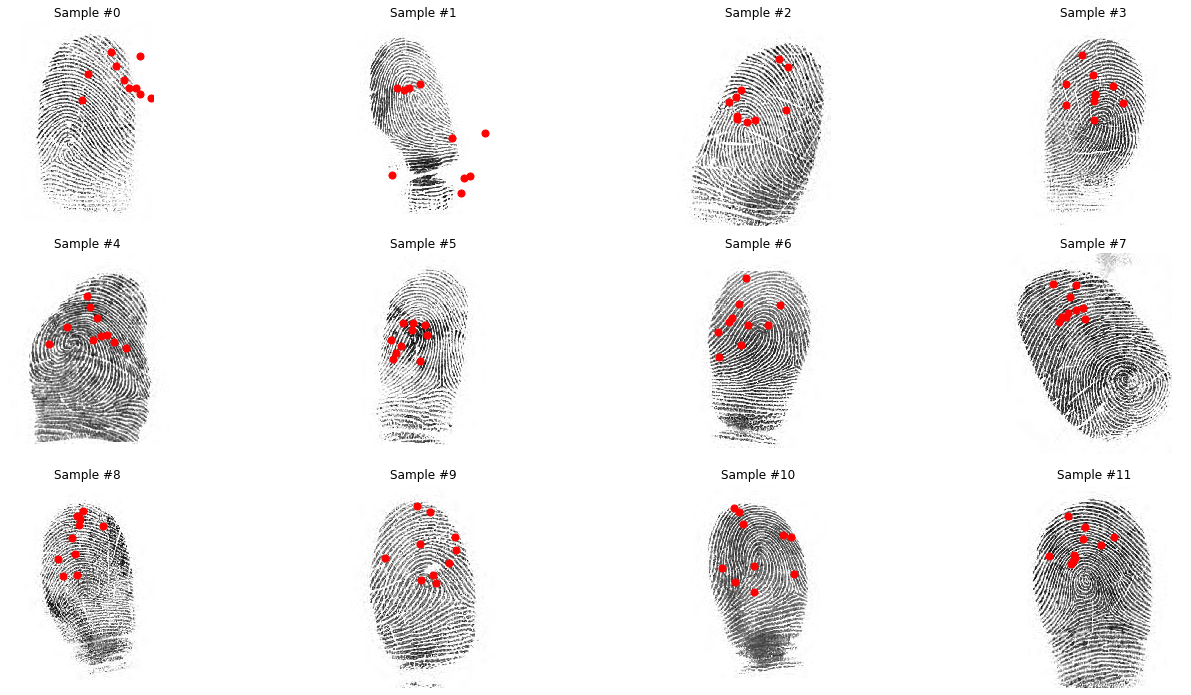

In [8]:
tech5_dataset = Tech5Dataset(root_dir=ROOT_DIR)

fig = plt.figure(figsize=(20,10))

for i in range(len(tech5_dataset)):
    sample = tech5_dataset[i]

    print(i, sample['image'].shape, sample['points'].shape)

    ax = plt.subplot(3, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_points(**sample)

    if i == 11:
        plt.show()
        break

In [9]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, points = sample['image'], sample['points']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        points = points * [new_w / w, new_h / h]

        return {'image': img, 'points': points}

In [10]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, points = sample['image'], sample['points']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        points = points - [left, top]

        return {'image': image, 'points': points}

In [11]:
class CenterCrop(object):
    """Crops the given PIL Image at the center.

    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, points = sample['image'], sample['points']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        start_h = (h - new_h) // 2
        start_w = (w - new_w) // 2

        image = image[start_h:start_h + new_h, start_w:start_w + new_w]

        return {'image': image, 'points': points}

In [12]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, points = sample['image'], sample['points']

        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'points': torch.from_numpy(points)}

In [13]:
transformed_dataset = Tech5Dataset(root_dir=ROOT_DIR,
                                   transform=\
                                   transforms.Compose([Rescale(256), CenterCrop(224), ToTensor()]))

In [14]:
train_ds, test_ds = random_split(transformed_dataset, [2720, 1165])

In [15]:
trainloader = DataLoader(train_ds, batch_size=5,
                        shuffle=True, num_workers=5)
testloader = DataLoader(test_ds, batch_size=5,
                        shuffle=True, num_workers=5)
dataloaders = {'train': trainloader, 'val': testloader}

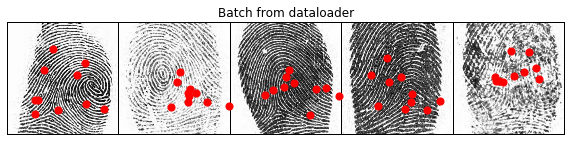

In [16]:
def show_points_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, points_batch = \
            sample_batched['image'], sample_batched['points']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch, nrow=20)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(points_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    points_batch[i, :, 1].numpy() + grid_border_size,
                    s=200, marker='.', c='r')

        plt.title('Batch from dataloader')

sample_batched = next(iter(trainloader))
plt.figure(figsize=(10,5))
show_points_batch(sample_batched)
plt.axis('off')
plt.ioff()
plt.show()


In [17]:
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 100)
model = model.to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
dataset_sizes = {'train': 3885, 'val':1165}

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 5000.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for sample in dataloaders[phase]:
                
                inputs = sample['image']
                labels = sample['points']
                labels = labels.view(1, 100)
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [20]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 27.5769
val Loss: 40.9699

Epoch 1/24
----------
train Loss: 25.9218
val Loss: 47.7388

Epoch 2/24
----------
train Loss: 25.6039
val Loss: 36.1931

Epoch 3/24
----------
train Loss: 25.2107
val Loss: 35.6903

Epoch 4/24
----------
train Loss: 25.2943
val Loss: 35.9538

Epoch 5/24
----------
train Loss: 24.9017
val Loss: 43.7984

Epoch 6/24
----------
train Loss: 24.7818
val Loss: 36.8862

Epoch 7/24
----------
train Loss: 24.2810
val Loss: 34.8359

Epoch 8/24
----------
train Loss: 24.1762
val Loss: 36.5942

Epoch 9/24
----------
train Loss: 24.1604
val Loss: 35.1483

Epoch 10/24
----------
train Loss: 24.1500
val Loss: 37.2563

Epoch 11/24
----------
train Loss: 24.1494
val Loss: 44.3133

Epoch 12/24
----------
train Loss: 24.1164
val Loss: 41.8176

Epoch 13/24
----------
train Loss: 24.1234
val Loss: 40.0462

Epoch 14/24
----------
train Loss: 24.0437
val Loss: 34.9437

Epoch 15/24
----------
train Loss: 24.0446
val Loss: 35.0018

Epoch 16/24
------

In [21]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.imshow(inp.numpy().transpose((1, 2, 0)))

    plt.pause(0.001) 

In [22]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, sample in enumerate(dataloaders['val']):
            inputs = sample['image']
            labels = sample['points']
            labels = labels.view(1, 100)
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            outputs = model(inputs)
            #_, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                labels = labels.view(inputs.size()[0], 10, 2)
                labels = labels.cpu()
                ax.scatter(labels[j, :, 0].numpy(),
                          labels[j, :, 1].numpy(),
                          s=30, marker='.', c='r')
                #print(outputs)
                preds = outputs[0, :].view(inputs.size()[0], 10, 2)
                preds = preds.cpu()
                ax.scatter(preds[j, :, 0].numpy(),
                          preds[j, :, 1].numpy(),
                          s=30, marker='.', c='b')
                
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


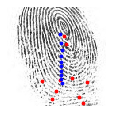

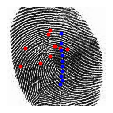

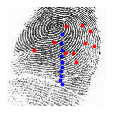

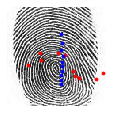

In [23]:
visualize_model(model)